In [45]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io as sio
import math
from scipy.optimize import minimize
#plt.style.use('ggplot')
plt.xkcd()

In [46]:
np.set_printoptions(suppress=True, precision=4)

In [47]:
data = sio.loadmat('ex4data1.mat')

In [48]:
X = data['X']
y = data['y']

m, n = X.shape
l = 1
num_labels = 10
hidden_layer_size = 25
input_layer_size = 400


In [49]:
def displayData(X, width=round(math.sqrt(X.shape[1]))):
    plt.figure(figsize=(10, 6))
    m, n = X.shape
    height = n // width
    
    display_rows = math.floor(math.sqrt(m))
    display_cols = math.ceil(m / display_rows)
    
    pad = 1
    
    display_array = -np.ones((pad + display_rows * (height + pad), \
                            pad + display_cols * (width + pad))) 
    curr_ex = 0
    for j in range(0, display_rows):
        for i in range(0, display_cols):
            max_val = np.absolute(X[curr_ex]).max()
            row, col = np.indices((height, width))
            display_array[pad + j * (height+pad) + row, \
                          pad + i * (width+pad) + col] = \
                            X[curr_ex].reshape(height, width, order='F') / max_val
                            #np.reshape(X[curr_ex], (height, width)) / max_val
            curr_ex += 1
        if curr_ex > m:
            break
    plt.imshow(display_array)

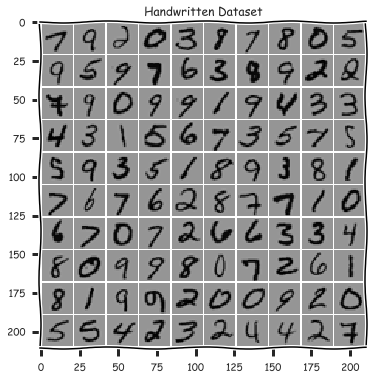

In [50]:
# Preview numbers
sel = X[np.random.randint(1, len(X), (100))] # Randomly select 100 numbers
displayData(sel)
plt.title('Handwritten Dataset')

In [51]:
weights = sio.loadmat('ex4weights.mat')

Theta1 = weights['Theta1']
Theta2 = weights['Theta2']

nn_params = np.r_[Theta1.ravel(order='F'), Theta2.ravel(order='F')]

In [52]:
def sigmoid(z):
    return 1. / (1. + np.exp(-z))

def sigmoidGradient(z):
    return sigmoid(z) * (1. - sigmoid(z))

def nnCostFunction(nn_params, input_layer_size,
                   hidden_layer_size, num_labels,
                   X, y, l):
    Theta1 = np.reshape(nn_params[:(input_layer_size+1)*hidden_layer_size],
                       (hidden_layer_size, input_layer_size+1), order='F')
    Theta2 = np.reshape(nn_params[(input_layer_size+1)*hidden_layer_size:],
                       (num_labels, hidden_layer_size+1), order='F')
    
    m, n = X.shape
    y_mat = (y == np.arange(1, num_labels+1)).astype(int) # Expand y to index logical array
    
    # Forward Propagation
    a1 = np.c_[np.ones((m, 1)), X]
    z2 = a1 @ Theta1.T
    a2 = np.c_[np.ones((m, 1)), sigmoid(z2)]
    z3 = a2 @ Theta2.T
    a3 = sigmoid(z3)
    
    J = 1/m * np.trace(-y_mat.T @ np.log(a3) - (1-y_mat).T @ np.log(1-a3))
    
    # Regularize cost
    Theta1_reg = Theta1[:, 1:]
    Theta2_reg = Theta2[:, 1:]
    
    J = J + l/(2*m) * (np.trace(Theta1_reg @ Theta1_reg.T) +
                       np.trace(Theta2_reg @ Theta2_reg.T))
    
    # Backpropagation
    d3 = a3 - y_mat
    d2 = d3 @ Theta2[:, 1:] * sigmoidGradient(z2)
    
    Theta1_grad = d2.T @ a1 / m
    Theta2_grad = d3.T @ a2 / m
    
    # Regularize gradient
    
    Theta1_grad[:, 1:] = Theta1_grad[:, 1:] + l/m * Theta1[:, 1:]
    Theta2_grad[:, 1:] = Theta2_grad[:, 1:] + l/m * Theta2[:, 1:]
    
    grad = np.r_[Theta1_grad.ravel(order='F'), Theta2_grad.ravel(order='F')]
    
    return J, grad

In [53]:
# Gradient Checking
def randInitializeWeights(L_in, L_out, debug=False):
    """Initializes weights with dimensions (L_in x L_out + 1)"""
    if debug:
        W = np.zeros((L_in, L_out+1))
        W = np.sin(np.arange(1, W.size+1)).reshape(W.shape) / 10
        return W
    else:
        epsilon = math.sqrt(6)/math.sqrt(L_in + L_out)
        return np.random.rand(L_out, 1 + L_in) * 2 * epsilon - epsilon        
    

def computeNumericalGradient(J, theta):
    numgrad = np.zeros(theta.shape)
    perturb = np.zeros(theta.shape)
    e=1e-4
    for p in range(theta.size):
        perturb[p] = e
        loss1,_ = J(theta - perturb)
        loss2,_ = J(theta + perturb)
        numgrad[p] = (loss2 - loss1) / (2*e)
        perturb[p] = 0
    return numgrad

def checkNNGradients(l=0):
    input_layer_size = 3
    hidden_layer_size = 5
    num_labels = 3
    m = 5
    
    Theta1 = randInitializeWeights(hidden_layer_size, input_layer_size, debug=True)
    Theta2 = randInitializeWeights(num_labels, hidden_layer_size, debug=True)
    nn_params = np.r_[Theta1.ravel(order='F'), Theta2.ravel(order='F')]
    
    X = randInitializeWeights(m, input_layer_size-1, debug=True)
    y = 1 + (np.mod(np.arange(1, m+1), num_labels)).reshape(m, 1)
    
    costFunc = lambda p: nnCostFunction(p, input_layer_size, hidden_layer_size, num_labels, X, y, l)
    _, grad = costFunc(nn_params)
    numgrad = computeNumericalGradient(costFunc, nn_params)
    
    print('Gradient, Numerical Gradient')
    print(np.c_[grad, numgrad])
    
    diff = np.linalg.norm(numgrad-grad)/np.linalg.norm(numgrad+grad)
    
    print('Relative difference: {}'.format(diff))
    

In [58]:
J, grad = nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, l)
grad.shape
type(J)

numpy.float64

In [62]:
grad

array([ 0.0001,  0.0001, -0.0002, ...,  0.0009,  0.0009,  0.0005])

In [55]:
# Randomly initialize parameters

Theta1_init = randInitializeWeights(input_layer_size, hidden_layer_size)
Theta2_init = randInitializeWeights(hidden_layer_size, num_labels)
nn_params_init = np.r_[Theta1_init.ravel(order='F'), Theta2_init.ravel(order='F')]

In [64]:
nn_params_init

array([-0.0265,  0.0447, -0.0066, ...,  0.1805,  0.3035,  0.1691])

In [44]:
res = minimize(nnCostFunction,
         x0=nn_params_init,
         args=(input_layer_size,
               hidden_layer_size,
               num_labels, X, y, l),
         method='CG',
         jac=True,
         options={'maxiter':400})

nn_params = res['x']
cost = res['fun']

Theta1 = np.reshape(nn_params[:(input_layer_size+1)*hidden_layer_size],
                    (hidden_layer_size, input_layer_size+1), order='F')
Theta2 = np.reshape(nn_params[(input_layer_size+1)*hidden_layer_size:],
                    (num_labels, hidden_layer_size+1), order='F')

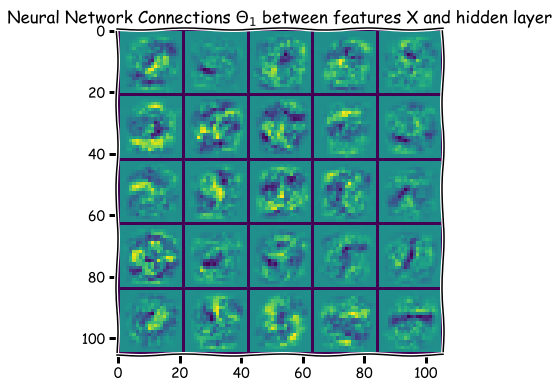

In [26]:
# Visualizing Neural Network weights
displayData(Theta1[:, 1:])
plt.title(r'Neural Network Connections $\Theta_1$ between features X and hidden layer')

In [343]:
# Calculating training accuracy

h1 = sigmoid(np.c_[np.ones((m, 1)), X] @ Theta1.T);
h2 = sigmoid(np.c_[np.ones((m, 1)), h1] @ Theta2.T);
pred = (np.argmax(h2, axis=1) + 1).reshape((m, 1))

accuracy = np.mean(pred == y) * 100
print('Training set accuracy: {}'.format(accuracy))

Training set accuracy: 99.6
